In [59]:
import numpy as np
import pandas as pd
# %matplotlib notebook
import pickle
import os
data_eval = pickle.load(open('./data/output/episode_encoded_lag_15_episode_model_v9_new_validation_set_include_smoking_focal_loss.p','rb'))

data_feature_label = pickle.load(open('./data/episode_encoded_lagged_data/episode_encoded_lagged_15_windows_standardized.p','rb'))

y_time = data_eval[0]
y_pred = data_eval[1]
y_test = data_eval[2]
y_pid = data_eval[3]
bias_dict = data_eval[4]
val_results = data_eval[5]

file1 = './data/mRisk/mRisk_lapse_final.csv'
if os.path.isfile(file1) == True:
    puff_data = pd.read_csv(file1)

def get_bias(key):
    val_par = val_results[key]
    time_gap_delta = 20
    gap_th = 55
    y_time = val_par[0]
    y_pred = val_par[1]
    y_test = val_par[2]
    y_pid = val_par[3]
    pars = np.unique(y_pid)
    total_lapsers = len(pars)
    bias_all = np.linspace(0.00001,.2,30)
    recall_all = []
    for bias in bias_all:
        final_intpday = []
        final_recall = []
        final_gap = []
        for timescap in range(10,60,4):
            total_ipd = 0
            part_days = 0
            lapse_captured = 0
            gap_s = []
            for i,par in enumerate(pars):
                a = np.where(y_pid==par)
                lapse_time = puff_data[puff_data['Participant']==int(par)]['Lapse'].values
                lapse_time = int(lapse_time[0])
                lapse_time = np.datetime64(lapse_time, 'ms') - np.timedelta64(5, 'h')
                y_pred_pid = y_pred[a]
                y_test_pid = y_test[a]
                y_time_pid = y_time[a]
                y_time_pid = np.array([y+np.timedelta64(time_gap_delta, 'm') for y in y_time_pid])
                y_pred_pid = y_pred_pid[y_time_pid.argsort()]
                y_test_pid = y_test_pid[y_time_pid.argsort()]
                y_time_pid = np.array(sorted(y_time_pid))
                # df = pd.DataFrame({'time':y_time_pid,'prob':y_pred_pid})
                # y_pred_pid = df['prob'].rolling(window=10).mean().fillna(0).values
                b = (np.where(y_test_pid>0))
                y_time_lapses = y_time_pid[b]
                udays = len(np.unique(data_feature_label[data_feature_label['user']==par]['day'].values))
                part_days+=udays
                ipd = 0
                int_given = False
                int_times = []
                for p,ys in enumerate(y_pred_pid):
                    if ys>=bias:
                        if int_given==False:
                            ipd+=1
                            int_time= y_time_pid[p]
                            prev_time = int_time
                            int_times.append(int_time)
                            int_given=True
                        else:
                            timedelta = y_time_pid[p] - prev_time
                            mins = timedelta.astype('timedelta64[m]').astype(np.int32)
                            if mins>timescap and ys>=bias:
                                ipd+=1
                                int_time= y_time_pid[p]
                                int_times.append(int_time)
                                prev_time = int_time
                try:
                    if len(np.intersect1d(int_times, y_time_lapses))>1:
                        gap_lapse_ = lapse_time - int_times[-1]
                        gap_lapse_ = gap_lapse_.astype('timedelta64[m]').astype(np.int32)
                        if gap_lapse_<gap_th:
                            lapse_captured+=1
                    total_ipd+=ipd
                    gap_lapse = lapse_time - int_times[-1]
                    gap_lapse = gap_lapse.astype('timedelta64[m]').astype(np.int32)
                    gap_s.append(gap_lapse)
                except:
                    pass
            final_day_th = float(total_ipd)/part_days
            final_intpday.append(final_day_th)
            final_gap.append(np.mean(gap_s))
            final_recall.append(float(lapse_captured)/total_lapsers)
        df = np.array(list(zip(final_intpday,final_recall)))
        recall_all.append(np.array([bias,df[df[:,0]<=10,1].max()]))
    recall_all = np.array(recall_all)
    try:
        return np.array([key,recall_all[recall_all[:,1]==recall_all[:,1].max(),0].mean()])
    except:
        return np.array([key,.1])

from joblib import Parallel,delayed
bias_col = Parallel(n_jobs=-1,verbose=2)(delayed(get_bias)(key) for key in val_results.keys())

bias_col = {int(a[0]):a[1] for a in bias_col}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   36.1s remaining:   31.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   51.2s finished


0.022288185 (0.20386799148332152, 0.022288185)
51
[0.7843137254901961, 0.7843137254901961, 0.7843137254901961, 0.7843137254901961, 0.7843137254901961, 0.7843137254901961, 0.7647058823529411, 0.7647058823529411, 0.7647058823529411, 0.7254901960784313, 0.6862745098039216, 0.6274509803921569, 0.5490196078431373, 0.45098039215686275, 0.4117647058823529, 0.39215686274509803, 0.29411764705882354, 0.27450980392156865, 0.17647058823529413, 0.09803921568627451, 0.0784313725490196, 0.13725490196078433, 0.19607843137254902, 0.0392156862745098, 0.0196078431372549]
0.7843137254901961
[20.35185185185185, 17.666666666666668, 15.62962962962963, 14.027777777777779, 12.694444444444445, 11.685185185185185, 10.814814814814815, 10.074074074074074, 9.38888888888889, 8.824074074074074, 8.36111111111111, 7.861111111111111, 7.537037037037037, 7.138888888888889, 6.833333333333333, 6.564814814814815, 6.314814814814815, 6.12962962962963, 5.87037037037037, 5.675925925925926, 5.583333333333333, 5.435185185185185, 5

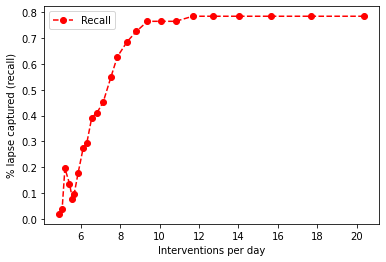

In [60]:
from sklearn import metrics
def f1Bias_scorer_CV(probs, y, ret_bias=True):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1,bias = 0.0,.5
    min_recall = .7
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and recall[i]>min_recall:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1
bias=f1Bias_scorer_CV(y_pred,y_test)[1]
# # bias = .1
print(bias,f1Bias_scorer_CV(y_pred,y_test))
time_gap_delta = 20
gap_th = 55
# for data in data_eval:
#     y_time.append(data[0])
#     y_pred.append(data[1])
#     y_test.append(data[2])
#     y_pid.append(data[3])
y_time = np.array(y_time)
y_pred = np.array(y_pred)
y_test = np.array(y_test)
y_pid = np.array(y_pid)
pars = np.unique(y_pid)
inc = ['3002', '3004', '3005', '3006', '3007', '3009', '3013', '3014', '3015', '3022', '3024', '3025', '3029', '3031', '3033',
 '3036', '3038', '3041', '3045', '3048', '3050', '3053', '3076', '3077', '3079', '3086', '3088', '3091', '3095', '3099',
 '3101', '3102', '3122', '3125', '3126', '3128', '3133', '3135', '3137', '3138', '3139', '3143', '3145', '3148', '3152',
 '3153', '3158', '3160', '3164', '3165', '3166', '3168']
pars=[p for p in pars if p in inc]
# pars=[p for p in pars if (p!='3099')]# and p!='3046' and p!='3086')]
# pars=[p for p in pars if (p!='3050' and p!='3122')]# and p!='3046' and p!='3086')]
total_lapsers = len(pars)
print(total_lapsers)
final_intpday = []
final_recall = []
final_gap = []
for timescap in range(10,60,2):
    total_ipd = 0
    part_days = 0
    lapse_captured = 0
    gap_s = []
    for i,par in enumerate(pars):
        val_pred = val_results[bias_dict[par]][1]
        val_y = val_results[bias_dict[par]][2]
        val_time = val_results[bias_dict[par]][0]
        val_pred = val_pred[val_time.argsort()]
        val_y = val_y[val_time.argsort()]
        val_time = np.array(sorted(val_time))
        df = pd.DataFrame({'time':val_time,'prob':val_pred})
        val_pred = df['prob'].rolling(window=10).mean().fillna(0).values
        bias = f1Bias_scorer_CV(val_pred,val_y)[1]
        # bias = bias_col[int(bias_dict[par])]
        # bias=f1Bias_scorer_CV(y_pred_pid,y_test_pid)[1]
#         bias = np.percentile(y_pred_pid,45)
        a = np.where(y_pid==par)
        lapse_time = puff_data[puff_data['Participant']==int(par)]['Lapse'].values
        lapse_time = int(lapse_time[0])
        lapse_time = np.datetime64(lapse_time, 'ms') - np.timedelta64(5, 'h')
        y_pred_pid = y_pred[a]
        y_test_pid = y_test[a]

        y_time_pid = y_time[a]
        y_time_pid = np.array([y+np.timedelta64(time_gap_delta, 'm') for y in y_time_pid])
        y_pred_pid = y_pred_pid[y_time_pid.argsort()]
        y_test_pid = y_test_pid[y_time_pid.argsort()]
        y_time_pid = np.array(sorted(y_time_pid))
        df = pd.DataFrame({'time':y_time_pid,'prob':y_pred_pid})
        y_pred_pid = df['prob'].rolling(window=10).mean().fillna(0).values
        b = (np.where(y_test_pid>0))
        y_time_lapses = y_time_pid[b]
        udays = len(np.unique(data_feature_label[data_feature_label['user']==par]['day'].values))
        part_days+=udays
        ipd = 0
        int_given = False
        int_times = []
        for p,ys in enumerate(y_pred_pid):
            if ys>=bias:
                if int_given==False:
                    ipd+=1
                    int_time= y_time_pid[p]
                    prev_time = int_time
                    int_times.append(int_time)
                    int_given=True
                else:
                    timedelta = y_time_pid[p] - prev_time
                    mins = timedelta.astype('timedelta64[m]').astype(np.int32)
                    if mins>timescap and ys>=bias:
                        ipd+=1
                        int_time= y_time_pid[p]
                        int_times.append(int_time)
                        prev_time = int_time
        try:
            if len(np.intersect1d(int_times, y_time_lapses))>1:
                gap_lapse_ = lapse_time - int_times[-1]
                gap_lapse_ = gap_lapse_.astype('timedelta64[m]').astype(np.int32)
                if gap_lapse_<gap_th:
                    lapse_captured+=1
            total_ipd+=ipd
            gap_lapse = lapse_time - int_times[-1]
            gap_lapse = gap_lapse.astype('timedelta64[m]').astype(np.int32)
            gap_s.append(gap_lapse)
        except:
            pass
    # print(len(gap_s))
    final_day_th = float(total_ipd)/part_days
    final_intpday.append(final_day_th)
    final_gap.append(np.mean(gap_s))
    final_recall.append(float(lapse_captured)/total_lapsers)


print(final_recall)
print(np.median(final_recall[:9]))
print(final_intpday)
print(final_gap)
import matplotlib.pyplot as plt
plt.plot(final_intpday,final_recall,linestyle='--', marker='o', color='r',label='Recall')
# plt.plot(final_intpday,final_,linestyle='--', marker='o', color='g',label='Precision')
# plt.plot(aaa[0],aaa[1],linestyle='--', marker='o', color='g',label="LSTM single")
plt.xlabel('Interventions per day')
plt.ylabel('% lapse captured (recall)')
# plt.ylabel('Gap between ID and Lapse')
# plt.ylim(30, 80)
plt.legend()
plt.show()


In [9]:
smoking_cross_entropy = [final_intpday,final_recall]

In [5]:
smoking_focal = [final_intpday,final_recall]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(aaa[0],aaa[1],linestyle='--', marker='o', color='r',label='LR')
plt.xlabel('Interventions per day')
# plt.ylabel('% lapse captured (recall)')
plt.ylabel('Gap between ID and Lapse')
# plt.ylim(30, 80)
plt.legend()
plt.show()

In [ ]:
aaa = [final_intpday,final_recall]